# Multimodal RAG using ColPali (with Byaldi) and Qwen2-VL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb)


[ColPali](https://huggingface.co/blog/manu/colpali) is a multimodal retriever that removes the need for hefty and brittle document processors. It natively handles images and processes and encodes image patches to be compatible with text, thus removing need to do OCR, or image captioning.

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

After indexing data, we will use [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to do generation part in RAG.

[Byaldi](https://github.com/AnswerDotAI/byaldi) is a new library by answer.ai to easily use ColPali. This library is in a very early stage, so this notebook will likely be updated soon with API changes.

## Install Byaldi

We will install byaldi using pip to get started.

We need to install transformers from main to get Qwen.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

Let's see how the PDF looks like.

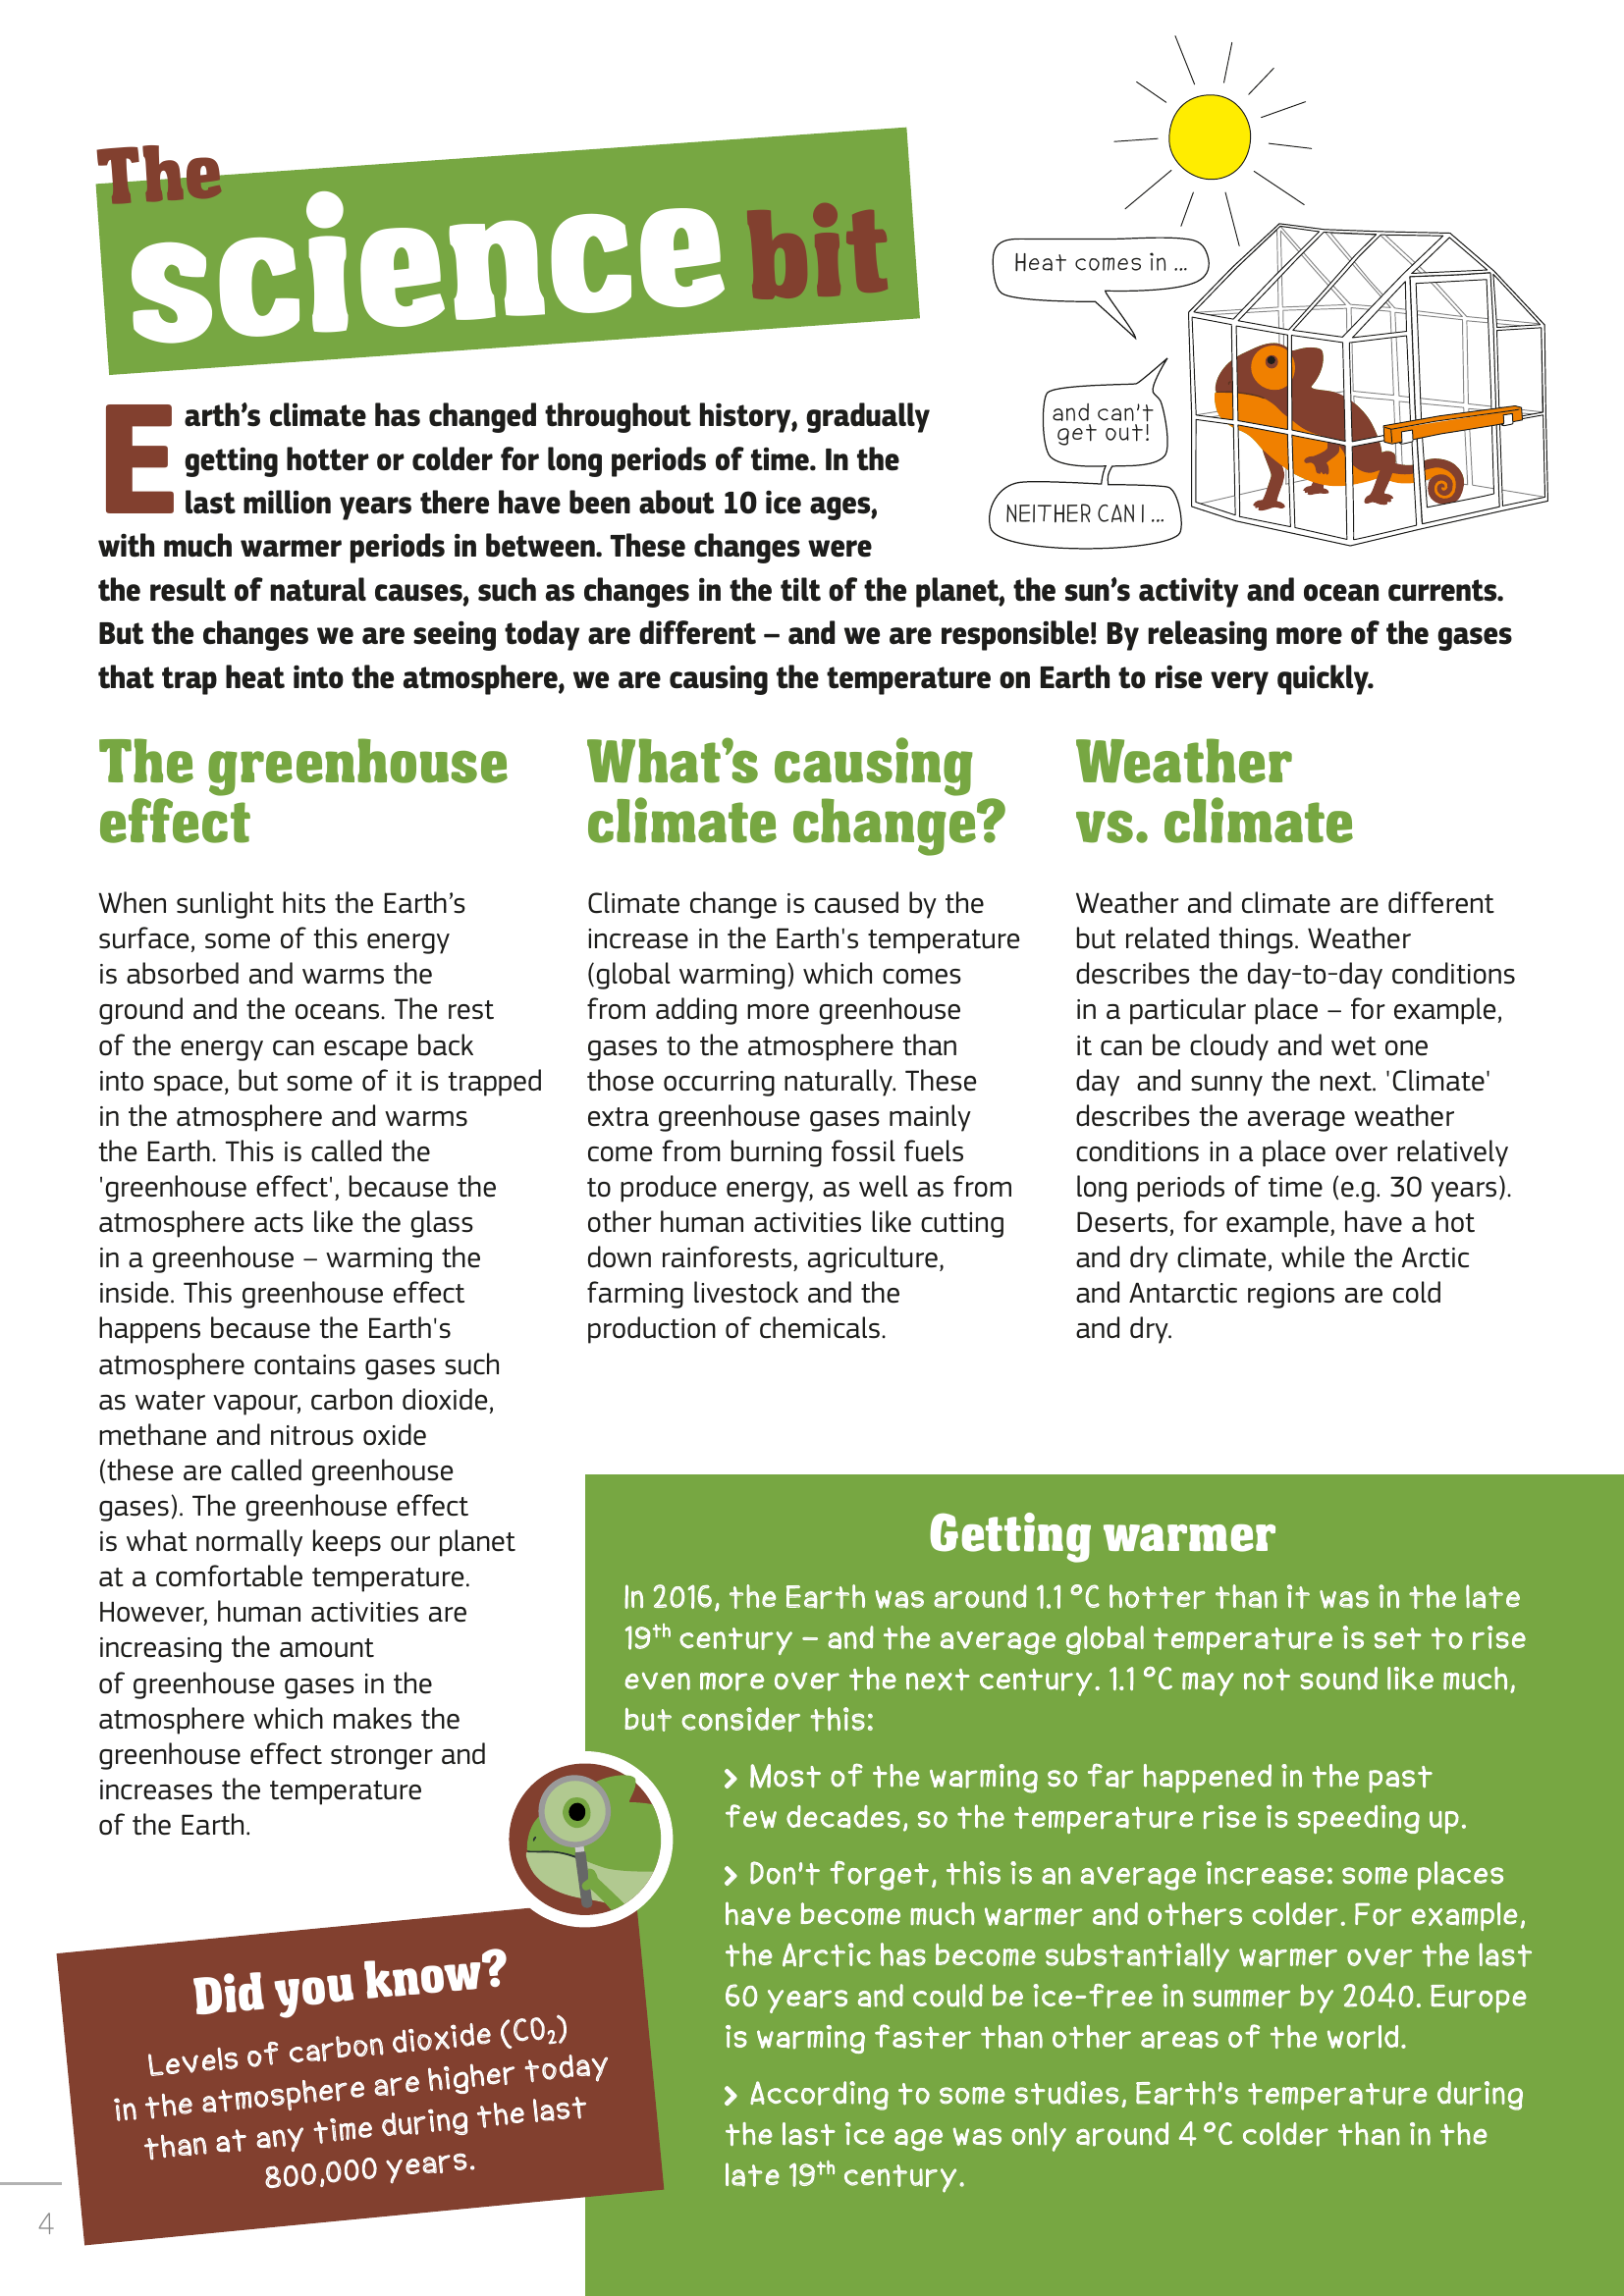

In [3]:
from pdf2image import convert_from_path

images = convert_from_path("content/climate_youth_magazine.pdf")
images[5]

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face. By default this model uses GPU but we are going to have Qwen2-VL in the same GPU so we are loading this in CPU for now.

In [5]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We can directly index our document using RAG, simply passing pdf file path is enough.

In [7]:
RAG.index(
    input_path="content/climate_youth_magazine.pdf",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of document 0 to index.
Added page 27 of docu

{0: 'content/climate_youth_magazine.pdf'}

Now let's retrieve!

In [8]:
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
results

[{'doc_id': 0, 'page_num': 6, 'score': 18.75, 'metadata': {}, 'base64': None}]

The answer was indeed on page 6, the one we accessed with `images[5]` above.

Now we can actually build a RAG pipeline. For this tutorial we will use Qwen2-VL-7B model.

In [9]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-2B-Instruct",
                                                        trust_remote_code=True, torch_dtype=torch.bfloat16).cuda().eval()

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [10]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [11]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [12]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [13]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 23.43 GiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 35.04 GiB is allocated by PyTorch, and 286.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(output_text)

["The Earth's average global temperature has increased by around 1.1°C since the late 19th century, according to the information provided in the image."]


This is the correct answer!

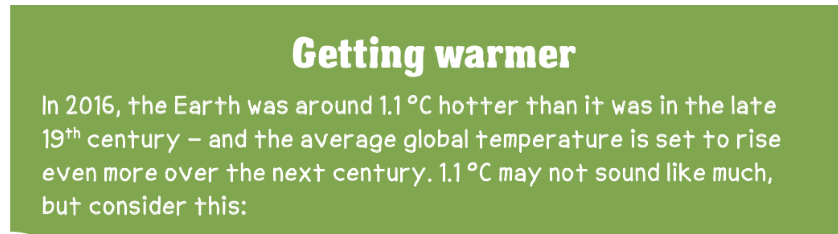